In [176]:
import functools
import time
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans

from magnolia.features.mixer import FeatureMixer
from magnolia.features.spectral_features import stft, istft, reconstruct 

import IPython
from IPython.display import Audio
from matplotlib import pyplot as plt
fig_size = [0,0]
fig_size[0] = 8
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

### Hyperparameters

In [169]:
# Size of BLSTM layers
layer_size = 600

# Size of embedding vectors
K = 50

# Size of training batches T = #windows F = #Frequency bins
T = 40
F = 257

# Training parameters
batch_size = 8

# STFT parameters used
sample_rate = 10e3
window_size = 0.0512
overlap = 0.0256
fft_size = 512

### Create feature mixers for training and validation sets

In [3]:
train_data = '/home/cstephenson/Data/librispeech/processed_train-clean-100.h5'
validation_data = '/home/cstephenson/Data/librispeech/processed_dev_clean.h5'

train_mixer = FeatureMixer([train_data,train_data], shape=(T,None))
validation_mixer = FeatureMixer([validation_data,validation_data], shape=(T,None))

### Functions for processing input data

In [4]:
def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases
    

def gen_batch(mixer,batch_size):
    X = np.zeros((batch_size,T,F))
    phases = np.zeros((batch_size,T,F))
    y = np.zeros((batch_size,T,F,2))
    
    for i in range(batch_size):
        data = next(mixer)
        
        X[i], _ = scale_spectrogram(data[0])
        phases[i] = np.unwrap(np.angle(data[0]))
        y[i,:,:,0] = 1/2*(np.sign(np.abs(data[1]) - np.abs(data[2])) + 1)
        y[i,:,:,1] = 1 - y[i,:,:,0]
    return X, y, phases

def invert_spectrogram(magnitude,phase):
    return istft(np.square(magnitude)*np.exp(phase*1.0j),sample_rate,None,overlap,two_sided=False,fft_size=fft_size)

### Defining the model

In [220]:
def scope(function):
    attribute = '_cache_' + function.__name__
    name = function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self,attribute):
            with tf.device("/gpu:0"):
                with tf.variable_scope(name):
                    setattr(self,attribute,function(self))
        return getattr(self,attribute)
    
    return decorator

class ClusterModel:
    def __init__(self, X, y, F, layer_size, embedding_size):
        self.X = X
        self.y = y
        
        self.F = F
        
        self.layer_size = layer_size
        self.embedding_size = embedding_size
        
        self.network
        self.cost
        self.optimizer
    
    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape, stddev=tf.sqrt(2.0/shape[0]))
        return tf.Variable(initial)
    
    def conv1d(self,x, W):
        return tf.nn.conv1d(x, W, stride=1, padding='SAME')
    
    def conv1d_layer(self,in_layer,shape):
        weights = self.weight_variable(shape)
        biases = self.weight_variable([shape[-1]])
        
        return self.conv1d(in_layer,weights) + biases
    
    def BLSTM(self, X, size, scope):
        forward_input = self.X
        backward_input = tf.reverse(self.X, [1])
        
        with tf.variable_scope('forward_' + scope):
            forward_lstm = tf.contrib.rnn.BasicLSTMCell(size//2)
            forward_out, f_state = tf.nn.dynamic_rnn(forward_lstm, forward_input, dtype=tf.float32)
        
        with tf.variable_scope('backward_' + scope):
            backward_lstm = tf.contrib.rnn.BasicLSTMCell(size//2)
            backward_out, b_state = tf.nn.dynamic_rnn(backward_lstm, backward_input, dtype=tf.float32)
        
        return tf.concat([forward_out[:,:,:], backward_out[:,::-1,:]], 2)
    
    @scope
    def network(self):
        shape = tf.shape(self.X)
        
        BLSTM_1 = self.BLSTM(self.X, self.layer_size, 'one')
        BLSTM_2 = self.BLSTM(BLSTM_1, self.layer_size, 'two')
        
        feedforward = self.conv1d_layer(BLSTM_2,[1,self.layer_size,self.embedding_size*self.F])
        
        embedding = tf.reshape(feedforward,[shape[0],shape[1],self.F,self.embedding_size]) 
        embedding = tf.nn.l2_normalize(embedding,3)
        
        return embedding
    
    @scope
    def cost(self):
        shape = tf.shape(self.y)
        Y = tf.reshape(y,[shape[0],shape[1]*shape[2],shape[3]])
        V = tf.reshape(self.network, [shape[0],shape[1]*shape[2],self.embedding_size])
        
        ones = tf.ones([shape[0],shape[1]*shape[2],1])
        mul_ones = tf.matmul(tf.transpose(Y, perm=[0,2,1]), ones)
        Diag = tf.matmul(Y, mul_ones)
        Diag = 1/tf.sqrt(Diag)
        Diag = tf.reshape(Diag,[shape[0],shape[1]*shape[2]])
        
        D = tf.matrix_diag(Diag)
        
        DV = tf.matmul(D,V)
        DY = tf.matmul(D,Y)
        
        VTV = tf.matmul(tf.transpose(V, perm=[0,2,1]), DV)
        VTY = tf.matmul(tf.transpose(V, perm=[0,2,1]), DY)
        YTY = tf.matmul(tf.transpose(Y, perm=[0,2,1]), DY)
        
        return tf.norm(VTV) - \
               2*tf.norm(VTY) + \
               tf.norm(YTY)

    @scope
    def optimizer(self):
        opt = tf.train.AdamOptimizer()
        cost = self.cost
        return opt.minimize(cost)

In [221]:
tf.reset_default_graph()

X = tf.placeholder("float", [None,None,F])
y = tf.placeholder("float", [None,None,F,2])

model = ClusterModel(X, y, F, layer_size, K)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

iterations = []
costs = []

print("Initialized")

Initialized


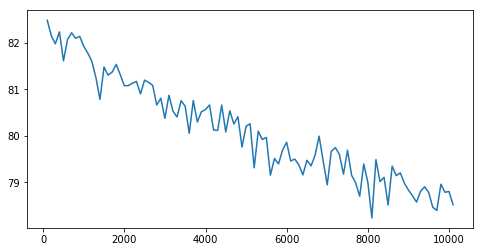

In [ ]:
X_train, y_train, phases = gen_batch(train_mixer,batch_size)

t_costs = []

if len(iterations) == 0:
    start = 0
else:
    start = iterations[-1]

for i in range(10000):
    X_train, y_train, phases = gen_batch(train_mixer,batch_size)
    c, _ = sess.run([model.cost, model.optimizer], {X: X_train, y: y_train})
    t_costs.append(c)
    
    if (i+1)%100 == 0:
        iterations.append(start + i)
        costs.append(np.mean(t_costs))
        t_costs = []
        
        IPython.display.clear_output(wait=True)
        plt.plot(iterations,costs)
        plt.show()

In [133]:
#X_train, y_train, phases = gen_batch(train_mixer,1)
out = sess.run(model.cost, {X: X_train, y: y_train})

In [245]:
vectors = sess.run(model.network,{X: X_train, y: y_train})
vectors.shape

(8, 40, 257, 50)

In [246]:
res = vectors[0].reshape((T*F,K))
resa = y_train[0].reshape((T*F,2))

In [247]:
A = resa @ resa.T
B = (res @ res.T)

In [248]:
np.mean(np.abs((res @ res.T) - A))

0.4833970729614831

In [196]:
np.mean(np.abs((res @ res.T) - A))

0.15046986559600753

In [127]:
A.shape

(10280, 10280)

In [249]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(vectors[0].reshape((T*F,K)))
mask = (kmeans.labels_).reshape(T,F)

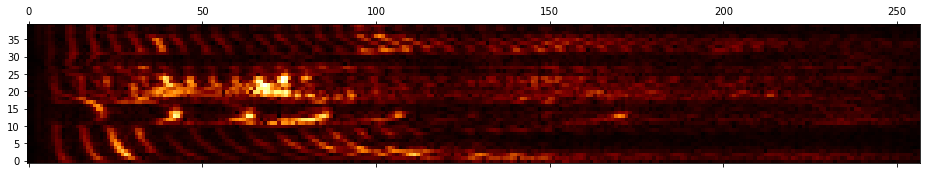

In [250]:
plt.matshow(X_train[0], origin='lower', cmap='afmhot')
plt.show()

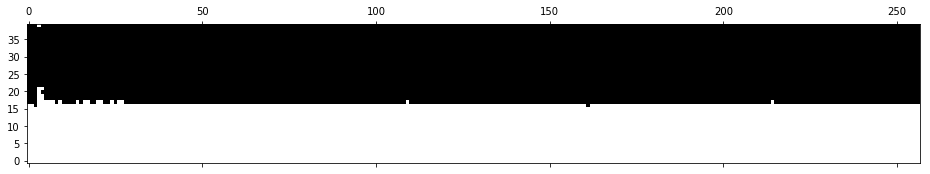

In [251]:
plt.matshow(mask, origin='lower', cmap='afmhot')
plt.show()

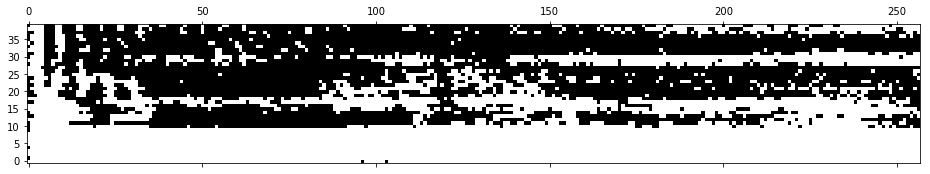

In [252]:
plt.matshow(y_train[0,:,:,1], origin='lower', cmap='afmhot')
plt.show()

In [ ]:
def separate(signal,model):
    spectrogram = stft(signal, sample_rate)
    M = np.sqrt(spectrogram.abs()).max()
    m = np.sqrt(spectrogram.abs()).min()
    
    X_in,phases = scale_spectrogram()
    
    vectors = sess.run(model.network,{X: X_in})
    

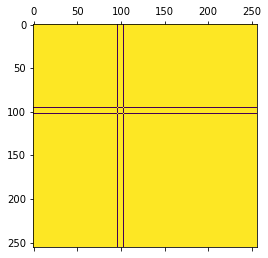

In [253]:
plt.matshow(A[0:256,0:256])
plt.show()

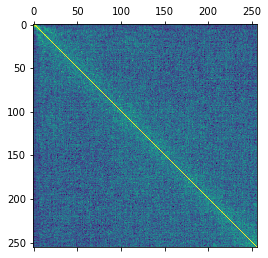

In [254]:
plt.matshow(B[0:256,0:256])
plt.show()

In [256]:
np.linalg.norm(B-A)

5047.2215615686719